# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import statsmodels.api as sm


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, RandomizedSearchCV, GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load the data 

In [3]:
df = pd.read_csv('data/Bengaluru_House_data_cleaned.csv')
df.head()

,location,total_sqft,bath,balcony,price,bhk,ready_to_move
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,0
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,0
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,1
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,0
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,0


# Get dummy data


In [4]:
df_dum = pd.get_dummies(df)
df_dum.head()

,total_sqft,bath,balcony,price,bhk,ready_to_move,location_1st Block Jayanagar,location_1st Phase JP Nagar,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,...,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur,location_others
0,2850.0,4.0,1.0,428.0,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,2.0,194.0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3.0,235.0,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,0.0,130.0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2.0,148.0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train-test split 

In [5]:
X = df_dum.drop(['price'],axis=1)
Y = df_dum.price

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [7]:
print(X.shape)
print(Y.shape)

(6892, 239)
(6892,)


# OLS Regression

In [8]:
'''
X_sm = sm.add_constant(X)
model = sm.OLS(Y,X_sm)
model.fit().summary()
'''

'\nX_sm = sm.add_constant(X)\nmodel = sm.OLS(Y,X_sm)\nmodel.fit().summary()\n'

# Linear Regression 

In [9]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [10]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.8485879725296794

## Using kfold validation to measure the accuracy of linear regression model 

In [11]:
print(cross_val_score(lr,X,Y,cv=cv))
np.mean(cross_val_score(lr,X,Y,cv=cv))

[0.84858797 0.85157332 0.82509898 0.85643028 0.83110133]


0.8425583775149497

# Lasso 

In [12]:
ls = Lasso()
ls.fit(X_train,y_train)
np.mean(cross_val_score(ls, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv))

-22.973013531267142

In [13]:
def find_best_model_using_grid_searchcv(X,y):
    algos ={
        'linear_regression':{
            'model': LinearRegression(),
            'param' : {
                'normalize' : [True, False]
            }
        },
        'lasso' :{
            'model' : Lasso(),
            'param' : {
                'alpha' : [1,2],
                'selection' : ['random','cyclic']
            }
        },
        'decision_tree':{
            'model' : DecisionTreeRegressor(),
            'param' : {
                'criterion' : ['mse','friedman_mse'],
                'splitter' : ['best','random']
            }
        }
    }
    
    scores= []
    CV = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['param'],cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model' : algo_name,
            'best_score' : gs.best_score_,
            'best_param' : gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_param'])

best_model = find_best_model_using_grid_searchcv(X,Y)
best_model

,model,best_score,best_param
0,linear_regression,0.842622,{'normalize': True}
1,lasso,0.716430,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.789749,"{'criterion': 'mse', 'splitter': 'random'}"


In [14]:
X.columns

Index(['total_sqft', 'bath', 'balcony', 'bhk', 'ready_to_move',
       'location_1st Block Jayanagar', 'location_1st Phase JP Nagar',
       'location_2nd Stage Nagarbhavi', 'location_5th Block Hbr Layout',
       'location_5th Phase JP Nagar',
       ...
       'location_Vishveshwarya Layout', 'location_Vishwapriya Layout',
       'location_Vittasandra', 'location_Whitefield',
       'location_Yelachenahalli', 'location_Yelahanka',
       'location_Yelahanka New Town', 'location_Yelenahalli',
       'location_Yeshwanthpur', 'location_others'],
      dtype='object', length=239)

In [15]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr.predict([x])[0]

In [16]:
predict_price('location_1st Block Jayanagar',1000,2,2)

194.57850156716734

In [17]:
predict_price('location_1st Block Jayanagar',1000,3,1)

199.60767794726848

In [18]:
import pickle

with open('banglore_house_price_model.pickle','wb') as f:
    pickle.dump(lr,f)

In [19]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

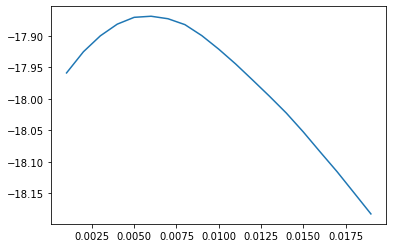

In [18]:
'''
alpha=[]
error=[]

for i in range(1,20):
    alpha.append(i/1000)
    lml = Lasso(alpha = (i/1000))
    error.append(np.mean(cross_val_score(lml,X_train,y_train,scoring = 'neg_mean_absolute_error', cv = cv)))
    
plt.plot(alpha, error)
'''


In [ ]:
err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns(['alpha,error']))
df_err[df_err.error == max(df_err.error)]

In [ ]:
lm_l = Lasso(alpha = 0.009)
lm_l.fit(X_train, y_train)
np.mean(cross_val_score(lm_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv=cv))

# Random Forest 

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= cv))

In [ ]:
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

In [ ]:
gs = RandomizedSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv = cv)

In [ ]:
gs.fit(X_train,y_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_

# MAE 

In [ ]:
pred_lm = lm.predict(X_test)
pred_lml = lm_l.predict(X_test)
pred_rf = gs.best_estimator_.predict(X_test)

In [ ]:
mae_lm = round(mean_absolute_error(y_test, pred_lm), 2)
mae_lml = round(mean_absolute_error(y_test, pred_lml), 2)
mae_rf = round(mean_absolute_error(y_test, pred_rf), 2)

In [ ]:
mae_lm = round(mean_absolute_error(y_test, pred_lm), 2)
mae_lml = round(mean_absolute_error(y_test, pred_lml), 2)
mae_rf = round(mean_absolute_error(y_test, pred_rf), 2)

# MAPE
